## Deep Learning Models

In [ ]:
#Importing Liraries

# Importing Libraries
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import shutil
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import random
import joblib
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.sparse import hstack
from wordcloud import WordCloud


# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer

# Modeling

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
#Metrics
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score





#Importing the Libraries
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

import tensorflow as tf
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Flatten,concatenate,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPool1D
from tensorflow.keras.models import Model


In [ ]:
X_train = pickle.load(open('X_train.pkl','rb'))
X_test = pickle.load(open('X_test.pkl','rb'))

In [ ]:
X_train.head()

,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_comment_message,day_to_delivery,words_per_review,sellers_count,products_count,est_delivery_t,act_delivery_t,diff_in_delivery_t,on_time_delivery,avg_prdt_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed,recency,frequency,monetary,RFM_Level
28832,delivered,1,boleto,1,95.21,13211,jundiai,SP,79.90,15.31,21.0,663.0,2.0,100.0,16.0,16.0,11.0,computers_accessories,neg _revej,22,1,6,1,31,19,12,1,79.90,95.21,0.191615,0,1,202,1,95.21,Potential
28103,delivered,1,credit_card,1,54.28,8215,sao paulo,SP,45.99,8.29,35.0,221.0,1.0,500.0,16.0,33.0,13.0,garden_tools,neg _revej,2,1,2,1,9,0,9,1,45.99,54.28,0.180257,6,1,133,1,54.28,Promising
76931,delivered,1,credit_card,1,171.62,22745,rio de janeiro,RJ,148.00,23.62,50.0,623.0,1.0,1200.0,19.0,18.0,16.0,sports_leisure,neg _revej,24,1,8,1,34,24,10,1,148.00,171.62,0.159595,3,1,157,1,171.62,Loyal
17603,delivered,1,credit_card,10,139.55,35519,nova serrana,MG,99.90,23.57,57.0,272.0,1.0,2500.0,40.0,10.0,30.0,furniture_decor,neg _revej,10,1,100,1,26,10,16,1,99.90,123.47,0.235936,2,1,200,1,139.55,Loyal
8208,delivered,1,boleto,1,82.91,20261,rio de janeiro,RJ,63.50,19.41,45.0,598.0,3.0,1100.0,33.0,13.0,22.0,perfumery,gost sab pq produt neg entreg gost soluç,33,14,1,1,29,32,-3,0,63.50,82.91,0.305669,3,1,122,1,82.91,Potential


In [ ]:
X_tr = pickle.load(open('X_tr.pkl', 'rb'))
X_te = pickle.load(open('X_te.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl','rb'))
y_test = pickle.load(open('y_test.pkl','rb'))

In [ ]:
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_tr)
print('X_train_encode',X_train_encode.shape)
# encode the test data
X_test_encode = encoder.predict(X_te)
print('X_test_encode',X_test_encode.shape)

X_train_encode (77804, 112)
X_test_encode (19451, 112)


In [ ]:
def confusion_matrices_plot(y_real, y_pred, y_test,y_test_pred,name):
    # representing confusion matric in heatmap format
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cmap_ = sns.light_palette("#425a90",as_cmap=True)
    cmap = sns.light_palette("#000000",as_cmap=True)
    C1 = confusion_matrix(y_real,y_pred)
    C2 = confusion_matrix(y_test,y_test_pred)
    
    fig,ax = plt.subplots(1, 2, figsize=(15,5))
    ax1 = sns.heatmap(C1, annot=True, cmap=cmap, fmt=".2f", ax = ax[0])
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion matrix")

    ax2 = sns.heatmap(C2, annot=True, cmap=cmap_, fmt=".2f", ax = ax[1])
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion matrix")
    plt.savefig(name, dpi=480, bbox_inches='tight')
    plt.show()

### Model-1

In [ ]:
#Custom metrics callbacks
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        
    def on_train_begin(self, logs={}):        
        self.micro_f1_score = []

     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()

        f1score = f1_score(val_targ, val_predict,average="macro")
        self.micro_f1_score.append(f1score)

        print("macro f1_score :",f1score)

In [ ]:
#RandomUniform initializer
initializer = tf.keras.initializers.HeUniform()

#Input layer
input_layer = Input( shape=(X_train_encode.shape[1],)) 
#Dense hidden layers
#1
layer1 = Dense(300,activation='relu',kernel_initializer=initializer,name='Dense_1' )(input_layer)
#2
layer2 = Dense(250,activation='relu',kernel_initializer=initializer,name='Dense_2')(layer1)
#3
layer3 = Dense(200,activation='relu',kernel_initializer=initializer,name='Dense_3')(layer2)
#4
layer4 = Dense(100,activation='relu',kernel_initializer=initializer,name='Dense_4')(layer3)
#5
layer5 = Dense(50,activation='relu',kernel_initializer=initializer,name='Dense_5')(layer4)
#output layer
output = Dense(1,activation='sigmoid',kernel_initializer=initializer,name='output_layer')(layer5)
output_layer = output
#Creating a model
model_1 = Model(inputs=input_layer,outputs=output_layer  )
print(model_1.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112)]             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 300)               33900     
_________________________________________________________________
Dense_2 (Dense)              (None, 250)               75250     
_________________________________________________________________
Dense_3 (Dense)              (None, 200)               50200     
_________________________________________________________________
Dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
Dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51    

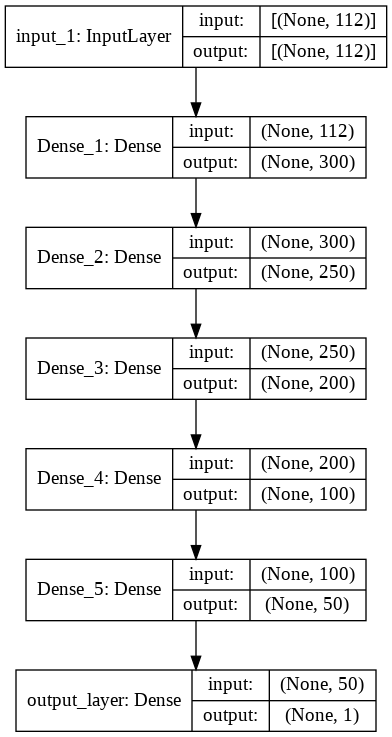

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_1plot.png', show_shapes=True, show_layer_names=True,)

In [ ]:
from keras import backend as K
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def f1(y_true, y_pred):
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
from tensorflow.keras import backend
backend.clear_session()

!rm -rf ./logs/


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

chk_pt=ModelCheckpoint(filepath="/content/drive/MyDrive/case study/models/model_1.h5",monitor='val_loss',verbose=1,save_best_only=True,mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_list = [chk_pt,early_stopping,rl,tensorboard_callback,Metrics(validation=(X_test_encode, y_test))]

In [ ]:
model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history=model_1.fit(X_train_encode, y_train, epochs=10,validation_data=(X_test_encode, y_test),callbacks=callback_list) 

Epoch 1/10
2432/2432 [==============================] - 9s 3ms/step - loss: 0.2726 - accuracy: 0.9274 - val_loss: 0.2574 - val_accuracy: 0.9071

Epoch 00001: val_loss improved from inf to 0.25744, saving model to /content/drive/MyDrive/case study/models/model_1.h5
macro f1_score : 0.8086489308267706
Epoch 2/10
2432/2432 [==============================] - 8s 3ms/step - loss: 0.1913 - accuracy: 0.9368 - val_loss: 0.2480 - val_accuracy: 0.9062

Epoch 00002: val_loss improved from 0.25744 to 0.24797, saving model to /content/drive/MyDrive/case study/models/model_1.h5
macro f1_score : 0.7922463417790946
Epoch 3/10
2432/2432 [==============================] - 8s 3ms/step - loss: 0.1904 - accuracy: 0.9361 - val_loss: 0.2674 - val_accuracy: 0.9077

Epoch 00003: val_loss did not improve from 0.24797
macro f1_score : 0.8055683529225439
Epoch 4/10
2432/2432 [==============================] - 7s 3ms/step - loss: 0.1868 - accuracy: 0.9374 - val_loss: 0.2555 - val_accuracy: 0.9073

Epoch 00004: val_

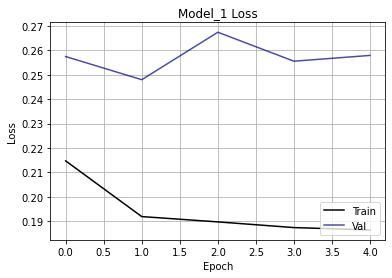

In [ ]:
plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model_1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('m1loss.png', dpi=480, bbox_inches='tight')
plt.show()

Train f1_score: 0.8726037552664443
Test f1_score: 0.8067202026817826


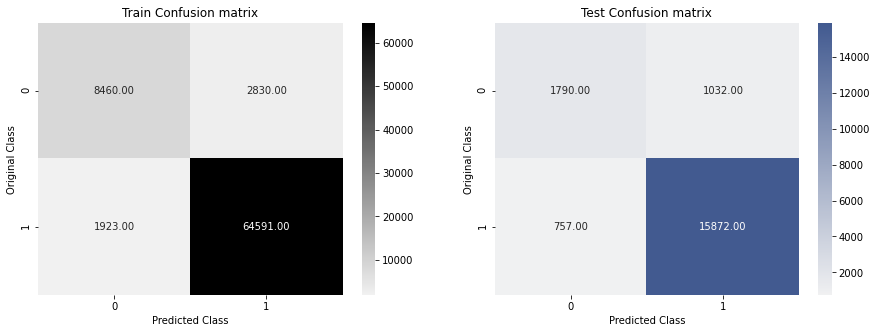

In [ ]:
y_train_pred1 = model_1.predict(X_train_encode)
y_test_pred1 = model_1.predict(X_test_encode)
y_train_pred = np.greater(y_train_pred1,0.5).astype(int)
y_test_pred = np.greater(y_test_pred1,0.5).astype(int)

print("Train f1_score:",f1_score(y_train,y_train_pred,average='macro'))

print("Test f1_score:",f1_score(y_test,y_test_pred,average='macro'))

confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'model_1.png')

### Model-2

In [ ]:
# Input to CNN and LSTMs
X_train_encode_1 = X_train_encode.reshape(X_train_encode.shape[0],X_train_encode.shape[1],1)
X_test_encode_1 = X_test_encode.reshape(X_test_encode.shape[0],X_test_encode.shape[1],1)
print("X_train_encode_1: ",X_train_encode_1.shape)
print("X_test_encode_1: ",X_test_encode_1.shape)


X_train_encode_1:  (77804, 112, 1)
X_test_encode_1:  (19451, 112, 1)


In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
from tensorflow.keras import backend
backend.clear_session()

!rm -rf ./logs/


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

chk_pt=ModelCheckpoint(filepath="/content/drive/MyDrive/case study/models/model_2.h5",monitor='val_loss',verbose=1,save_best_only=True,mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_list = [chk_pt,early_stopping,rl,tensorboard_callback,Metrics(validation=(X_test_encode_1, y_test))]

In [ ]:
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense,Input,Conv1D,MaxPooling1D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model


input = Input(shape=X_train_encode_1.shape[1:],name='sent_input')

conv_m = layers.Conv1D(128, 5, activation="relu",name="Conv1D_with_filter_size_m")(input)
conv_n = layers.Conv1D(120, 5, activation="relu",name="Conv1D_with_filter_size_n")(conv_m)

max_pool_1 = MaxPooling1D(pool_size=2)(conv_n)

conv_k = layers.Conv1D(96, 5, activation="relu",name="Conv1D_with_filter_size_k")(max_pool_1)
conv_t = layers.Conv1D(88, 5, activation="relu",name="Conv1D_with_filter_size_t")(conv_k)


max_pool_2 = MaxPooling1D(pool_size=5)(conv_t)



flatten = layers.Flatten()(max_pool_2)
dropouts = layers.Dropout(0.6)(flatten)
dense_1 = layers.Dense(40, activation="relu")(dropouts)
output = layers.Dense(1, activation="sigmoid",name= 'Output' )(dense_1)

model_2 = Model(input, output)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent_input (InputLayer)      [(None, 112, 1)]          0         
_________________________________________________________________
Conv1D_with_filter_size_m (C (None, 108, 128)          768       
_________________________________________________________________
Conv1D_with_filter_size_n (C (None, 104, 120)          76920     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 52, 120)           0         
_________________________________________________________________
Conv1D_with_filter_size_k (C (None, 48, 96)            57696     
_________________________________________________________________
Conv1D_with_filter_size_t (C (None, 44, 88)            42328     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 88)             0   

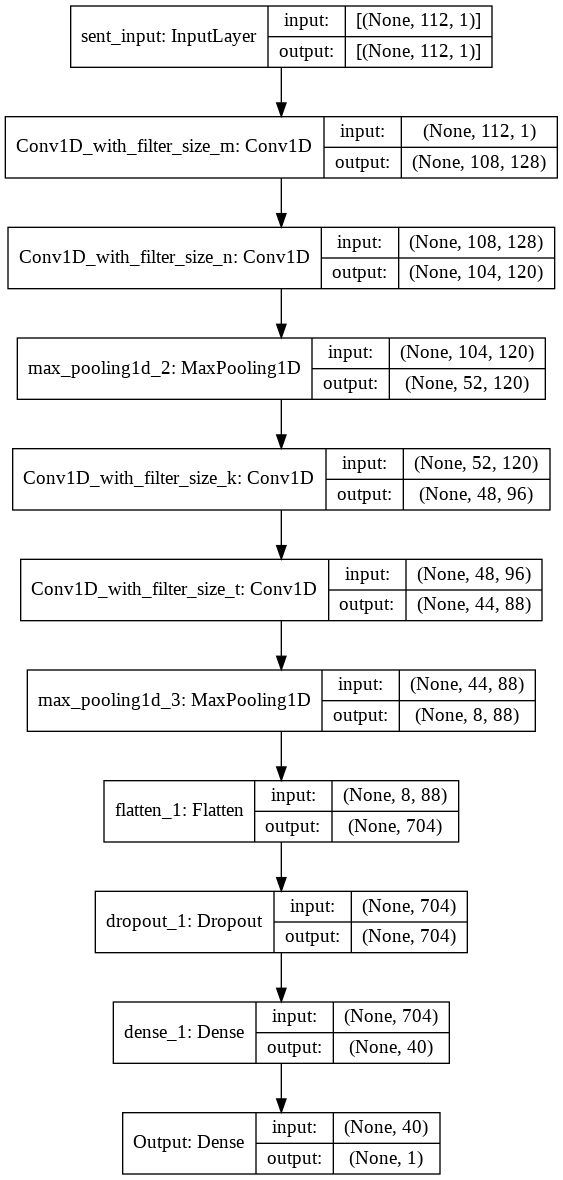

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_2plot.png', show_shapes=True, show_layer_names=True,)

In [ ]:
model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history= model_2.fit(X_train_encode_1, y_train, epochs=10,validation_data=(X_test_encode_1, y_test),callbacks=callback_list) 

Epoch 1/10
2432/2432 [==============================] - 14s 5ms/step - loss: 0.2189 - accuracy: 0.9267 - val_loss: 0.2511 - val_accuracy: 0.9078

Epoch 00001: val_loss improved from inf to 0.25106, saving model to /content/drive/MyDrive/case study/models/model_2.h5
macro f1_score : 0.8078301785296063
Epoch 2/10
2432/2432 [==============================] - 11s 5ms/step - loss: 0.1938 - accuracy: 0.9353 - val_loss: 0.2465 - val_accuracy: 0.9070

Epoch 00002: val_loss improved from 0.25106 to 0.24646, saving model to /content/drive/MyDrive/case study/models/model_2.h5
macro f1_score : 0.8090169854201168
Epoch 3/10
2432/2432 [==============================] - 11s 5ms/step - loss: 0.1867 - accuracy: 0.9371 - val_loss: 0.2472 - val_accuracy: 0.9060

Epoch 00003: val_loss did not improve from 0.24646
macro f1_score : 0.8090561787808956
Epoch 4/10
2432/2432 [==============================] - 11s 5ms/step - loss: 0.1869 - accuracy: 0.9380 - val_loss: 0.2457 - val_accuracy: 0.9080

Epoch 00004: 

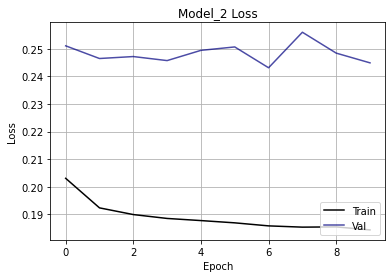

In [ ]:
plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model_2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('m2loss.png', dpi=480, bbox_inches='tight')
plt.show()

Train f1_score: 0.8740313979727979
Test f1_score: 0.8091884392072531


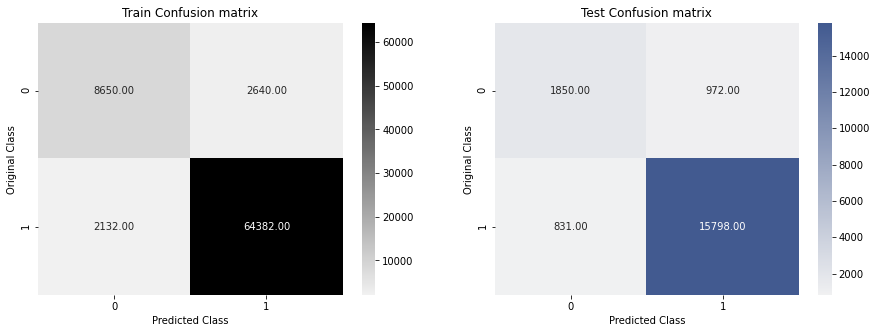

In [ ]:
y_train_pred1 = model_2.predict(X_train_encode_1)
y_test_pred1 = model_2.predict(X_test_encode_1)
y_train_pred = np.greater(y_train_pred1,0.5).astype(int)
y_test_pred = np.greater(y_test_pred1,0.5).astype(int)

print("Train f1_score:",f1_score(y_train,y_train_pred,average='macro'))

print("Test f1_score:",f1_score(y_test,y_test_pred,average='macro'))

confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'model_2.png')

## Model-3

In [ ]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(77804, 36) (19451, 36)
(77804,) (19451,)


In [ ]:
X_train.head()

,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_comment_message,day_to_delivery,words_per_review,sellers_count,products_count,est_delivery_t,act_delivery_t,diff_in_delivery_t,on_time_delivery,avg_prdt_value,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed,recency,frequency,monetary,RFM_Level
28832,delivered,1,boleto,1,95.21,13211,jundiai,SP,79.90,15.31,21.0,663.0,2.0,100.0,16.0,16.0,11.0,computers_accessories,neg _revej,22,1,6,1,31,19,12,1,79.90,95.21,0.191615,0,1,202,1,95.21,Potential
28103,delivered,1,credit_card,1,54.28,8215,sao paulo,SP,45.99,8.29,35.0,221.0,1.0,500.0,16.0,33.0,13.0,garden_tools,neg _revej,2,1,2,1,9,0,9,1,45.99,54.28,0.180257,6,1,133,1,54.28,Promising
76931,delivered,1,credit_card,1,171.62,22745,rio de janeiro,RJ,148.00,23.62,50.0,623.0,1.0,1200.0,19.0,18.0,16.0,sports_leisure,neg _revej,24,1,8,1,34,24,10,1,148.00,171.62,0.159595,3,1,157,1,171.62,Loyal
17603,delivered,1,credit_card,10,139.55,35519,nova serrana,MG,99.90,23.57,57.0,272.0,1.0,2500.0,40.0,10.0,30.0,furniture_decor,neg _revej,10,1,100,1,26,10,16,1,99.90,123.47,0.235936,2,1,200,1,139.55,Loyal
8208,delivered,1,boleto,1,82.91,20261,rio de janeiro,RJ,63.50,19.41,45.0,598.0,3.0,1100.0,33.0,13.0,22.0,perfumery,gost sab pq produt neg entreg gost soluç,33,14,1,1,29,32,-3,0,63.50,82.91,0.305669,3,1,122,1,82.91,Potential


In [ ]:
X_train_txt = X_train['review_comment_message']
X_train_txt.head()

28832                                  neg _revej
28103                                  neg _revej
76931                                  neg _revej
17603                                  neg _revej
8208     gost sab pq produt neg entreg gost soluç
Name: review_comment_message, dtype: object

In [ ]:
X_test_txt = X_test['review_comment_message']
X_test_txt.head()

57579    apes compr ter sid efetu carnav cheg sup rápid
20490                                        neg _revej
41178       produt bonit aind ótim qual satisfeit compr
17887                                        neg _revej
18384                                        neg _revej
Name: review_comment_message, dtype: object

In [ ]:
X_train_os= X_train['order_status']
X_test_os = X_test['order_status']

In [ ]:
X_train_pt= X_train['payment_type']
X_test_pt = X_test['payment_type']

In [ ]:
X_train_st= X_train['customer_state']
X_test_st = X_test['customer_state']

In [ ]:
X_train_pc= X_train['product_category_name_english']
X_test_pc = X_test['product_category_name_english']

In [ ]:
X_train_rfm = X_train['RFM_Level']
X_test_rfm  = X_test['RFM_Level']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer =  Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded


In [ ]:
tokenizer = create_tokenizer(X_train_txt)
# calculate max document length
length = max_length(X_train_txt)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_txt = encode_text(tokenizer, X_train_txt, length)
testX_txt = encode_text(tokenizer,X_test_txt, length)
print(trainX_txt.shape, testX_txt.shape)

Max document length: 37
Vocabulary size: 7177
(77804, 37) (19451, 37)


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7177

In [ ]:
from gensim.models import FastText
ft_model = FastText.load_fasttext_format('/content/drive/MyDrive/case study/cc.pt.300.bin')

In [ ]:
ft_words = list(ft_model.wv.vocab.keys()) # list(embeddings.keys())
len(ft_words)

2000000

In [ ]:
# creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word,i in word_index.items():
  if word in ft_words:
    embedding_vector = ft_model.wv[str(word)]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = np.zeros_like(ft_model.wv['produt'])


print(embedding_matrix.shape)

(7177, 300)


In [ ]:
from tensorflow.keras.layers import Embedding
num_tokens = vocab_size
embedding_dim = 300

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    input_length = length,
    name='1'
 )

In [ ]:
tokenizer = create_tokenizer(X_train_os)
# calculate max document length
length = max_length(X_train_os)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_os = encode_text(tokenizer, X_train_os, length)
testX_os = encode_text(tokenizer,X_test_os, length)
print(trainX_os.shape, testX_os.shape)

Max document length: 1
Vocabulary size: 8
(77804, 1) (19451, 1)


In [ ]:
tokenizer = create_tokenizer(X_train_pt)
# calculate max document length
length = max_length(X_train_pt)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_pt = encode_text(tokenizer, X_train_pt, length)
testX_pt = encode_text(tokenizer,X_test_pt, length)
print(trainX_pt.shape, testX_pt.shape)

Max document length: 1
Vocabulary size: 5
(77804, 1) (19451, 1)


In [ ]:
tokenizer = create_tokenizer(X_train_st)
# calculate max document length
length = max_length(X_train_st)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_st = encode_text(tokenizer, X_train_st, length)
testX_st = encode_text(tokenizer,X_test_st, length)
print(trainX_st.shape, testX_st.shape)

Max document length: 1
Vocabulary size: 28
(77804, 1) (19451, 1)


In [ ]:
tokenizer = create_tokenizer(X_train_pc)
# calculate max document length
length = max_length(X_train_pc)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_pc = encode_text(tokenizer, X_train_pc, length)
testX_pc = encode_text(tokenizer,X_test_pc, length)
print(trainX_pc.shape, testX_pc.shape)

Max document length: 1
Vocabulary size: 72
(77804, 1) (19451, 1)


In [ ]:
tokenizer = create_tokenizer(X_train_rfm)
# calculate max document length
length = max_length(X_train_rfm)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX_rfm = encode_text(tokenizer, X_train_rfm, length)
testX_rfm = encode_text(tokenizer,X_test_rfm, length)
print(trainX_rfm.shape, testX_rfm.shape)

Max document length: 3
Vocabulary size: 12
(77804, 3) (19451, 3)


In [ ]:
# numerical features
num=['payment_sequential',
 'payment_installments',
 'payment_value',
 'customer_zip_code_prefix',
 'price',
 'freight_value',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'day_to_delivery',
 'recency',
 'frequency',
 'monetary',
 'sellers_count',
 'products_count',
 'est_delivery_t',
 'act_delivery_t',
 'diff_in_delivery_t',
 'on_time_delivery',
 'avg_prdt_value',
 'total_order_cost',
 'order_freight_ratio',
 'purchase_dayofweek',
 'is_reviewed','words_per_review']

In [ ]:
from sklearn.preprocessing import Normalizer
def normalizer(col):
  normalizer = Normalizer()
  normalizer.fit(X_train[col].values.reshape(1,-1))
  X_train_norm = normalizer.transform(X_train[col].values.reshape(-1,1))
  X_test_norm = normalizer.transform(X_test[col].values.reshape(-1,1))
  return X_train_norm,X_test_norm

In [ ]:
tr=[]
te=[]
for i in num:
  a,b = normalizer(i)
  tr.append(a)
  te.append(b)

In [ ]:
from scipy.sparse import hstack,csr_matrix
import numpy as np

X_tr_num_1 = np.hstack((tr))
X_te_num_1 = np.hstack((te))


print("Final Data matrix")
print(X_tr_num_1.shape, y_train.shape)
print(X_te_num_1.shape, y_test.shape)

Final Data matrix
(77804, 29) (77804,)
(19451, 29) (19451,)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv1D,MaxPooling1D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

#Input layes
input_1 = keras.Input(shape=(37,), dtype="int32",name="Input_seq_total_text_data")
input_2 = keras.Input(shape=(1,), dtype="int32",name="Input_order_status")
input_3 = keras.Input(shape=(1,), dtype="int32",name="payment_type")
input_4 = keras.Input(shape=(1,), dtype="int32",name="Input_customer_state")
input_5 = keras.Input(shape=(1,), dtype="int32",name="Input_product_category")
input_6 = keras.Input(shape=(3,), dtype="int32",name="Input_rfm")
input_7 = keras.Input(shape=(29,), dtype="int32",name="Input_numerical")

#Embedding Layers
embd_layer_1 = embedding_layer(input_1)
embd_layer_2 = layers.Embedding(8,2,name="2")(input_2)
embd_layer_3 = layers.Embedding(5,2,name="3")(input_3)
embd_layer_4 = layers.Embedding(28,2,name="4")(input_4)
embd_layer_5 = layers.Embedding(72,2,name="5")(input_5)
embd_layer_6 = layers.Embedding(12,2,name="6")(input_6)

#lstm
lstm_1 = layers.LSTM(123,recurrent_dropout=0.3,return_sequences=True,name='lstm')(embd_layer_1)

#flatten layer
flatten_1 = layers.Flatten()(lstm_1)
flatten_2 = layers.Flatten()(embd_layer_2)
flatten_3 = layers.Flatten()(embd_layer_3)
flatten_4 = layers.Flatten()(embd_layer_4)
flatten_5 = layers.Flatten()(embd_layer_5)
flatten_6 = layers.Flatten()(embd_layer_6)

#dense
dense_1 = layers.Dense(16,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer=regularizers.l2(0.0001))(input_7)
#concat
concat = layers.concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_1])

#dense
dense_2 = layers.Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer=regularizers.l2(0.0001))(concat)

#dropout
drpout_1 =  layers.Dropout(.5)(dense_2)

#dense
dense_3 = layers.Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer=regularizers.l2(0.0001))(drpout_1)
#dropout
drpout_2 =  layers.Dropout(.5)(dense_3)
x=tf.keras.layers.BatchNormalization()(drpout_2)
#dense
dense_3 = layers.Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer=regularizers.l2(0.0001))(x)
drpout_3 =  layers.Dropout(.5)(dense_3)
#output
output = layers.Dense(1,activation= "sigmoid", name="output")(drpout_3)


model = keras.Model([input_1,input_2,input_3,input_4,input_5,input_6,input_7], output, name="Model_1")
model.summary()


Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_seq_total_text_data (Inpu [(None, 37)]         0                                            
__________________________________________________________________________________________________
1 (Embedding)                   (None, 37, 300)      2153100     Input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
Input_order_status (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
payment_type (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
x_train=[trainX_txt, trainX_os, trainX_pt, trainX_st, trainX_pc, trainX_rfm, X_tr_num_1]

In [ ]:
x_test =[testX_txt, testX_os, testX_pt, testX_st, testX_pc, testX_rfm, X_te_num_1]

In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
from tensorflow.keras import backend
backend.clear_session()

!rm -rf ./logs/


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

chk_pt=ModelCheckpoint(filepath="/content/drive/MyDrive/case study/models/model_3.h5",monitor='val_loss',verbose=1,save_best_only=True,mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

callback_list = [chk_pt,early_stopping,rl,tensorboard_callback,Metrics(validation=(x_test, y_test))]

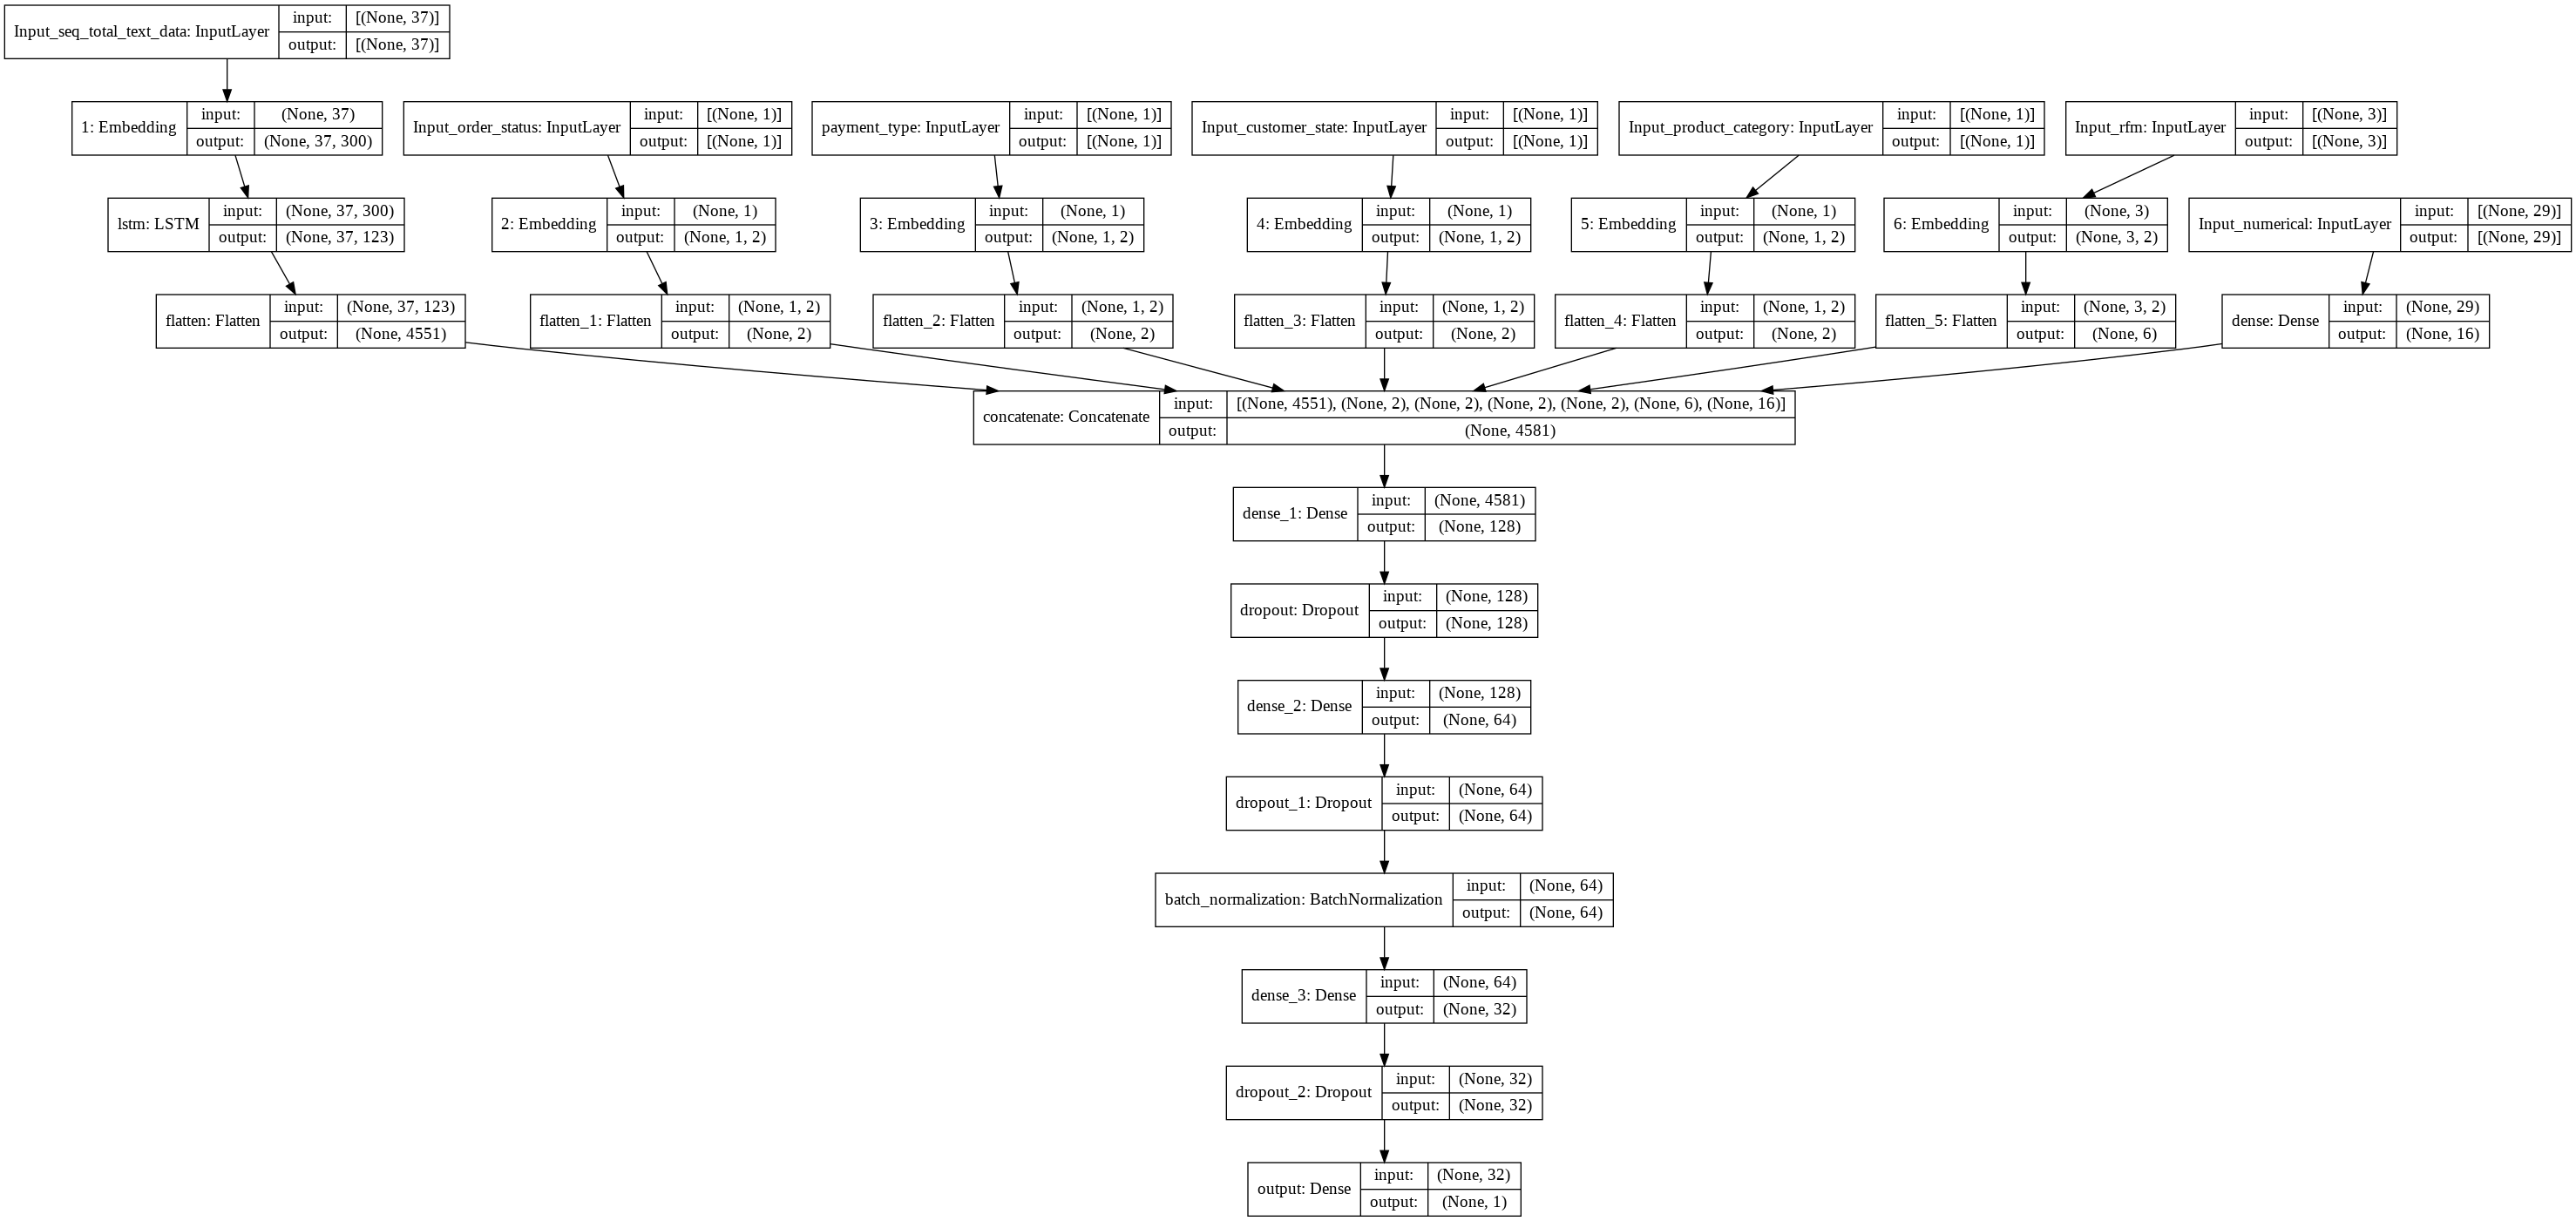

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_3plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=callback_list) 

Epoch 1/10
2432/2432 [==============================] - 286s 116ms/step - loss: 0.4453 - accuracy: 0.8361 - val_loss: 0.2836 - val_accuracy: 0.9022

Epoch 00001: val_loss improved from inf to 0.28358, saving model to /content/drive/MyDrive/case study/models/model_3.h5
macro f1_score : 0.7895729783011742
Epoch 2/10
2432/2432 [==============================] - 276s 114ms/step - loss: 0.2798 - accuracy: 0.9024 - val_loss: 0.2540 - val_accuracy: 0.9147

Epoch 00002: val_loss improved from 0.28358 to 0.25403, saving model to /content/drive/MyDrive/case study/models/model_3.h5
macro f1_score : 0.8172992896500759
Epoch 3/10
2432/2432 [==============================] - 275s 113ms/step - loss: 0.2594 - accuracy: 0.9085 - val_loss: 0.2503 - val_accuracy: 0.9081

Epoch 00003: val_loss improved from 0.25403 to 0.25026, saving model to /content/drive/MyDrive/case study/models/model_3.h5
macro f1_score : 0.7726110385997698
Epoch 4/10
2432/2432 [==============================] - 273s 112ms/step - los

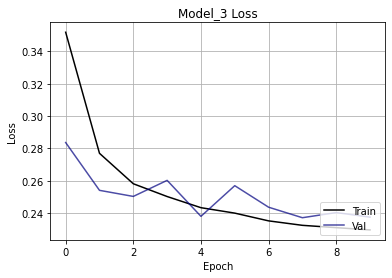

In [ ]:
plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model_3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('m3loss.png', dpi=480, bbox_inches='tight')
plt.show()

Train f1_score: 0.8636603564776757
Test f1_score: 0.8238907987030571


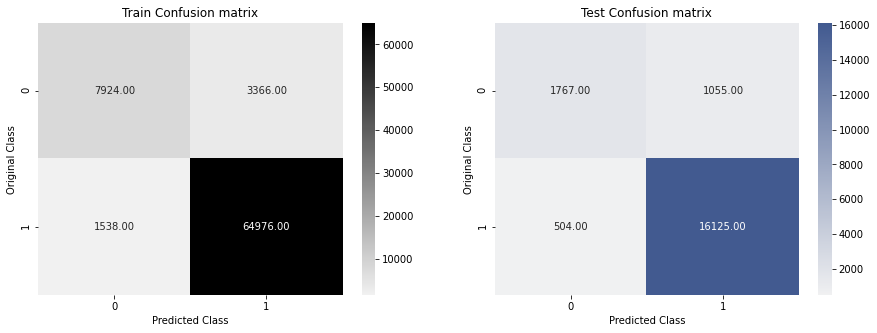

In [ ]:
y_train_pred1 = model.predict(x_train)
y_test_pred1 = model.predict(x_test)
y_train_pred = np.greater(y_train_pred1,0.5).astype(int)
y_test_pred = np.greater(y_test_pred1,0.5).astype(int)

print("Train f1_score:",f1_score(y_train,y_train_pred,average='macro'))

print("Test f1_score:",f1_score(y_test,y_test_pred,average='macro'))

confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'model_3.png')

## Model-4

In [ ]:

vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['order_status'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
order_st_tr = vectorizer.transform(X_train['order_status'].values)

order_st_te = vectorizer.transform(X_test['order_status'].values)

print("After vectorizations")
print(order_st_tr.shape, y_train.shape)
print(order_st_tr.shape, y_test.shape)


After vectorizations
(77804, 7) (77804,)
(77804, 7) (19451,)


In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['payment_type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
pay_typ_tr = vectorizer.transform(X_train['payment_type'].values)

pay_typ_te = vectorizer.transform(X_test['payment_type'].values)

print("After vectorizations")
print(pay_typ_tr.shape, y_train.shape)
print(pay_typ_tr.shape, y_test.shape)


After vectorizations
(77804, 4) (77804,)
(77804, 4) (19451,)


In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['product_category_name_english'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
prod_cat_tr = vectorizer.transform(X_train['product_category_name_english'].values)

prod_cat_te = vectorizer.transform(X_test['product_category_name_english'].values)

print("After vectorizations")
print(prod_cat_tr.shape, y_train.shape)
print(prod_cat_tr.shape, y_test.shape)


After vectorizations
(77804, 71) (77804,)
(77804, 71) (19451,)


In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['customer_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
state_tr = vectorizer.transform(X_train['customer_state'].values)

state_te = vectorizer.transform(X_test['customer_state'].values)

print("After vectorizations")
print(state_tr.shape, y_train.shape)
print(state_tr.shape, y_test.shape)


After vectorizations
(77804, 27) (77804,)
(77804, 27) (19451,)


In [ ]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['RFM_Level'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
rfm_tr = vectorizer.transform(X_train['RFM_Level'].values)

rfm_te = vectorizer.transform(X_test['RFM_Level'].values)

print("After vectorizations")
print(rfm_tr.shape, y_train.shape)
print(rfm_tr.shape, y_test.shape)


After vectorizations
(77804, 11) (77804,)
(77804, 11) (19451,)


In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_num = hstack((order_st_tr,pay_typ_tr,prod_cat_tr,state_tr,rfm_tr,X_tr_num_1)).tocsr()
X_te_num = hstack((order_st_te,pay_typ_te,prod_cat_te,state_te,rfm_te,X_te_num_1)).tocsr()



In [ ]:
x_tr_num = np.array(X_tr_num.todense()).reshape(X_tr_num.shape[0],X_tr_num.shape[1],1)

x_te_num = np.array(X_te_num.todense()).reshape(X_te_num.shape[0],X_te_num.shape[1],1)

In [ ]:
print("Final Data matrix")
print(x_tr_num.shape, y_train.shape)

print(x_te_num.shape, y_test.shape)
print("="*100)
print('')

Final Data matrix
(77804, 149, 1) (77804,)
(19451, 149, 1) (19451,)



In [ ]:
#input
input_1 = keras.Input(shape=(37,), dtype="int32",name="input_seq_total_text_data")
input_2 = keras.Input(shape=(149,1),name="Other_than_text_data")

#Embedding Layers
embd_layer_1 = embedding_layer(input_1)

#lstm
lstm_1 = layers.LSTM(123,return_sequences=True,name='lstm')(embd_layer_1)

#conv1d
conv_1 = layers.Conv1D(128, 3, activation="relu")(input_2)
conv_2 = layers.Conv1D(64, 3, activation="relu")(conv_1)

#flatten layer
flatten_1 = layers.Flatten()(lstm_1)
flatten_2 = layers.Flatten()(conv_2)
#concat
concat = layers.concatenate([flatten_1,flatten_2])

#dense
dense_1 = layers.Dense(60)(concat)

#dropout
drpout_1 =  layers.Dropout(.6)(dense_1)

#dense
dense_2 = layers.Dense(30)(drpout_1)
#dropout
drpout_2 =  layers.Dropout(.4)(dense_2)
b = tf.keras.layers.BatchNormalization()(drpout_2)
#dense
dense_3 = layers.Dense(15)(b)
x = layers.Dropout(0.6)(dense_3)
#output
output = layers.Dense(1,activation= "sigmoid", name="output")(x)

model = keras.Model([input_1,input_2], output, name="Model_4")
model.summary()


Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 37)]         0                                            
__________________________________________________________________________________________________
Other_than_text_data (InputLaye [(None, 149, 1)]     0                                            
__________________________________________________________________________________________________
1 (Embedding)                   (None, 37, 300)      2153100     input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 147, 128)     512         Other_than_text_data[0][0]       
____________________________________________________________________________________________

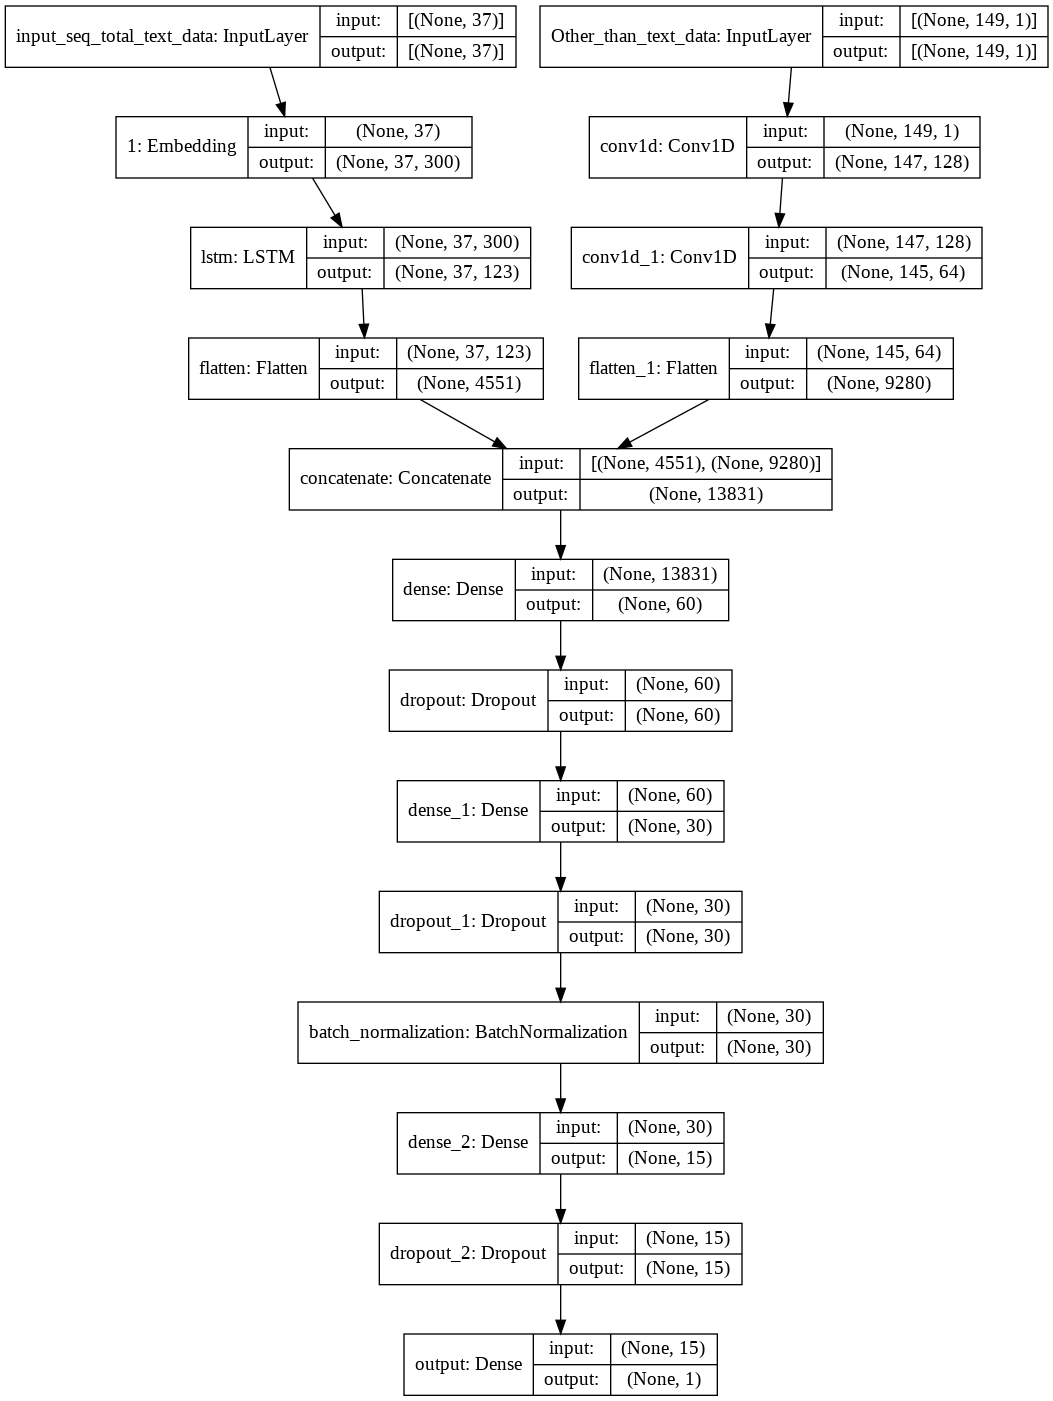

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_train=[trainX_txt,x_tr_num]

In [ ]:
x_test=[testX_txt,x_te_num]

In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
from tensorflow.keras import backend
backend.clear_session()

!rm -rf ./logs/


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

chk_pt=ModelCheckpoint(filepath="/content/drive/MyDrive/case study/models/model_4.h5",monitor='val_loss',verbose=1,save_best_only=True,mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


callback_list = [chk_pt,early_stopping,rl,tensorboard_callback,Metrics(validation=(x_test, y_test))]

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=callback_list) 

Epoch 1/10
2432/2432 [==============================] - 22s 8ms/step - loss: 0.4567 - accuracy: 0.8366 - val_loss: 0.2338 - val_accuracy: 0.9121

Epoch 00001: val_loss improved from inf to 0.23381, saving model to /content/drive/MyDrive/case study/models/model_4.h5
macro f1_score : 0.8041287175090144
Epoch 2/10
2432/2432 [==============================] - 18s 8ms/step - loss: 0.2485 - accuracy: 0.9087 - val_loss: 0.2274 - val_accuracy: 0.9124

Epoch 00002: val_loss improved from 0.23381 to 0.22739, saving model to /content/drive/MyDrive/case study/models/model_4.h5
macro f1_score : 0.7950234584679547
Epoch 3/10
2432/2432 [==============================] - 19s 8ms/step - loss: 0.2419 - accuracy: 0.9119 - val_loss: 0.2265 - val_accuracy: 0.9132

Epoch 00003: val_loss improved from 0.22739 to 0.22652, saving model to /content/drive/MyDrive/case study/models/model_4.h5
macro f1_score : 0.7992016720404043
Epoch 4/10
2432/2432 [==============================] - 18s 8ms/step - loss: 0.2326 - 

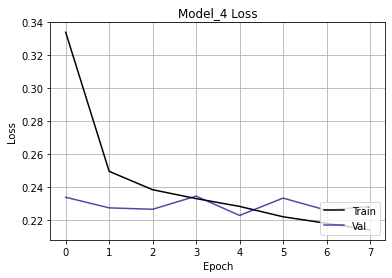

In [ ]:
plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model_4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('m4loss.png', dpi=480, bbox_inches='tight')
plt.show()

Train f1_score: 0.8615208408122796
Test f1_score: 0.8123570318544904


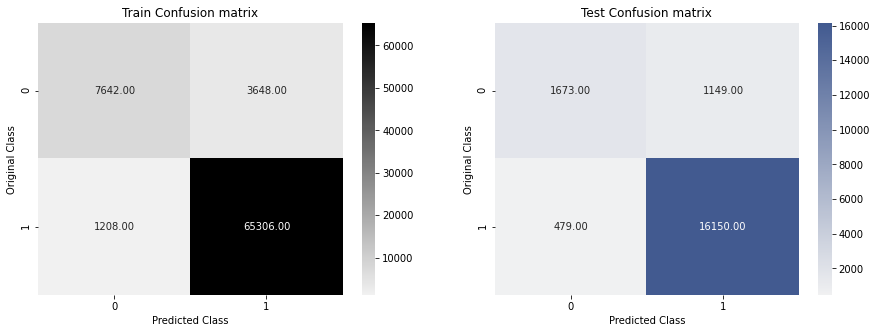

In [ ]:
y_train_pred1 = model.predict(x_train)
y_test_pred1 = model.predict(x_test)
y_train_pred = np.greater(y_train_pred1,0.5).astype(int)
y_test_pred = np.greater(y_test_pred1,0.5).astype(int)

print("Train f1_score:",f1_score(y_train,y_train_pred,average='macro'))

print("Test f1_score:",f1_score(y_test,y_test_pred,average='macro'))

confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'model_4.png')

### Model-5

In [ ]:
#input
input_1 = keras.Input(shape=(37,), dtype="int32",name="input_seq_total_text_data")
input_2 = keras.Input(shape=(149,),name="Other_than_text_data")
#Embedding Layers
embd_layer_1 = embedding_layer(input_1)

conv_m = layers.Conv1D(128, 5, activation="relu",name="Conv1D_with_filter_size_m")(embd_layer_1)
#lstm
lstm_1 = layers.LSTM(123,return_sequences=True,name='lstm')(conv_m)
conv_n = layers.Conv1D(120, 5, activation="relu",name="Conv1D_with_filter_size_n")(lstm_1)
lstm_2 = layers.LSTM(123,return_sequences=True,name='lstm_1')(conv_n)
#flatten layer
flatten_1 = layers.Flatten()(lstm_2)
drpout_0 =  layers.Dropout(.7)(flatten_1)
b_0 = tf.keras.layers.BatchNormalization()(drpout_0)
#dense
dense_1 = layers.Dense(60)(input_2)
dense_2 = layers.Dense(60)(dense_1)

#concat
concat = layers.concatenate([b_0,dense_2])
drpout_1 =  layers.Dropout(.4)(concat)
b_1 = tf.keras.layers.BatchNormalization()(drpout_1)
dense_3 = layers.Dense(60)(b_1)
b_2 = tf.keras.layers.BatchNormalization()(dense_3)
dense_4 = layers.Dense(30)(b_2)
#dropout
drpout_2 =  layers.Dropout(.4)(dense_4)
b = tf.keras.layers.BatchNormalization()(drpout_2)
#output
output = layers.Dense(1,activation= "sigmoid", name="output")(b)
model = keras.Model([input_1,input_2], output, name="Model_5")
model.summary()

Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 37)]         0                                            
__________________________________________________________________________________________________
1 (Embedding)                   (None, 37, 300)      2153100     input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
Conv1D_with_filter_size_m (Conv (None, 33, 128)      192128      1[15][0]                         
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 33, 123)      123984      Conv1D_with_filter_size_m[0][0]  
____________________________________________________________________________________________

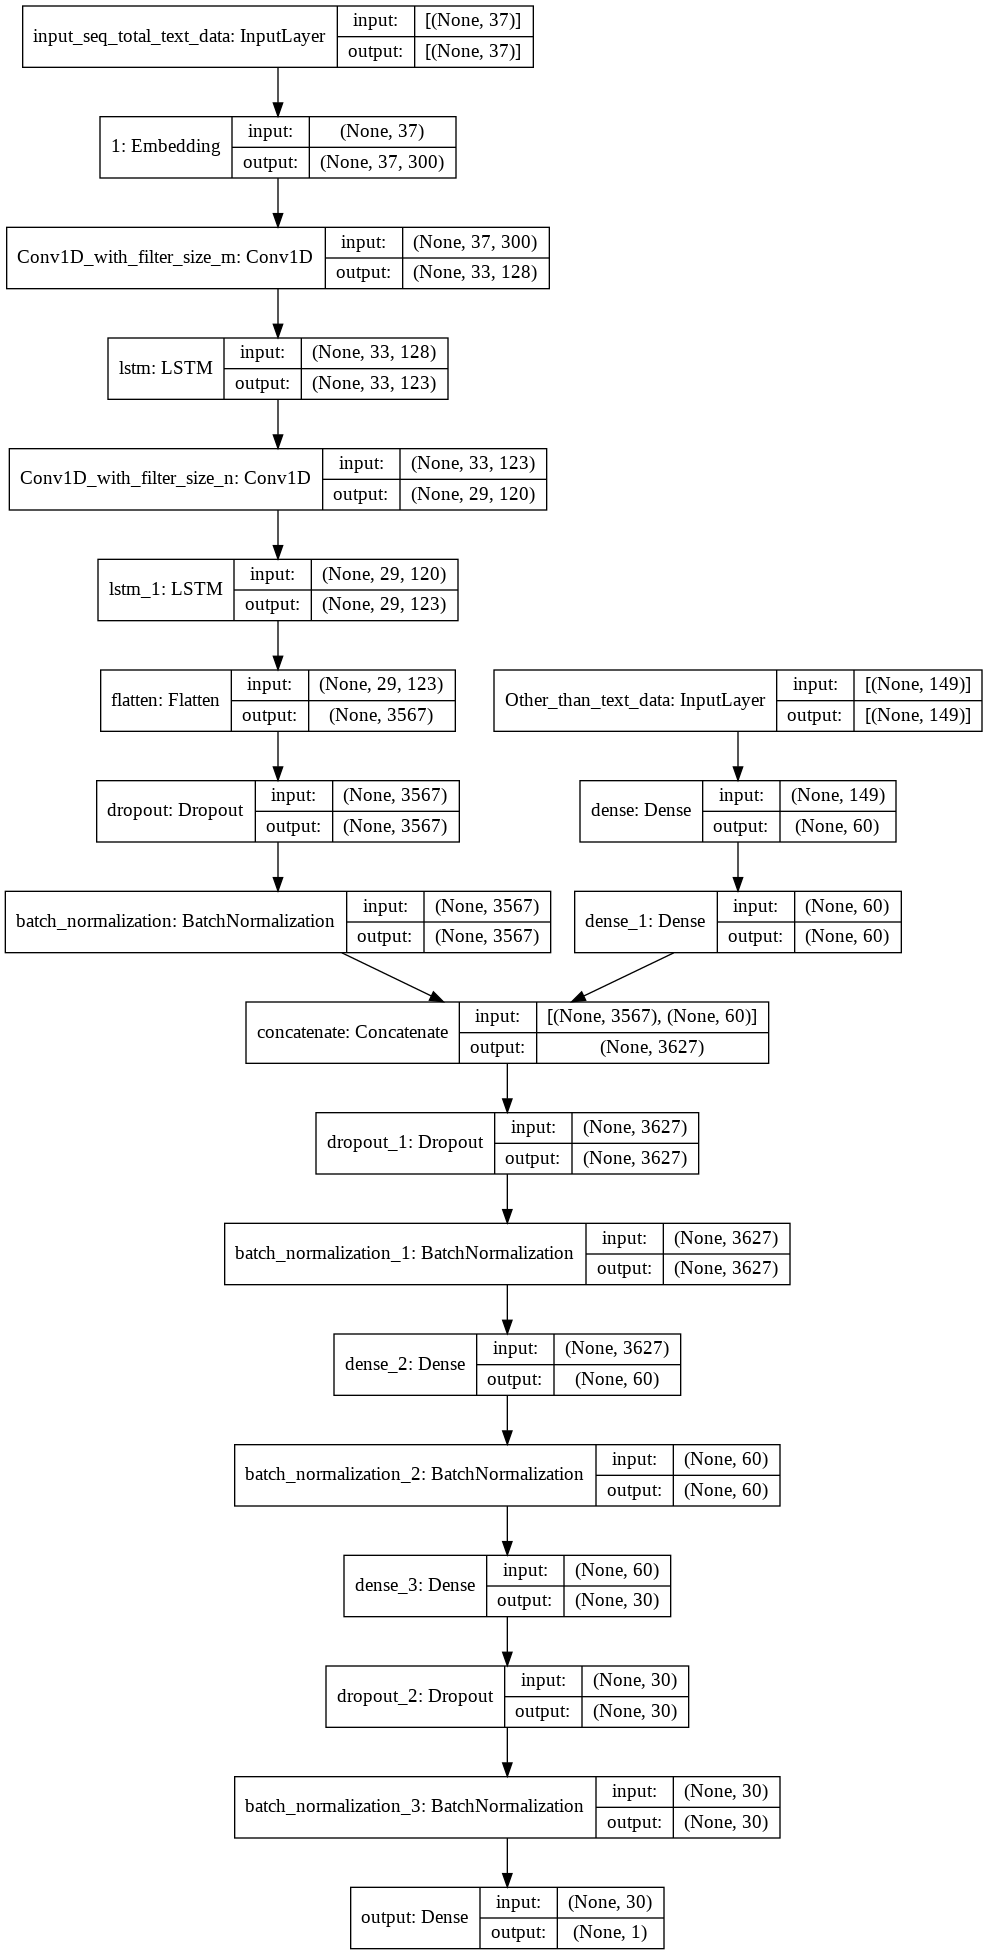

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_5.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_train_n=[trainX_txt,X_tr_num]
x_test_n=[testX_txt,X_te_num]

In [ ]:

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import datetime
from tensorflow.keras import backend
backend.clear_session()

!rm -rf ./logs/


log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

chk_pt=ModelCheckpoint(filepath="/content/drive/MyDrive/case study/models/model_5.h5",monitor='val_loss',verbose=1,save_best_only=True,mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


callback_list = [chk_pt,early_stopping,rl,tensorboard_callback,Metrics(validation=(x_test_n, y_test))]

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(x_train_n, y_train, epochs=10,validation_data=(x_test_n, y_test),callbacks=callback_list) 

Epoch 1/10
2432/2432 [==============================] - 40s 14ms/step - loss: 0.3718 - accuracy: 0.8528 - val_loss: 0.2512 - val_accuracy: 0.9099

Epoch 00001: val_loss improved from inf to 0.25124, saving model to /content/drive/MyDrive/case study/models/model_5.h5
macro f1_score : 0.8243679116943432
Epoch 2/10
2432/2432 [==============================] - 32s 13ms/step - loss: 0.2410 - accuracy: 0.9076 - val_loss: 0.3522 - val_accuracy: 0.8665

Epoch 00002: val_loss did not improve from 0.25124
macro f1_score : 0.7784791255573553
Epoch 3/10
2432/2432 [==============================] - 31s 13ms/step - loss: 0.2351 - accuracy: 0.9090 - val_loss: 0.2345 - val_accuracy: 0.9153

Epoch 00003: val_loss improved from 0.25124 to 0.23452, saving model to /content/drive/MyDrive/case study/models/model_5.h5
macro f1_score : 0.8185033453784349
Epoch 4/10
2432/2432 [==============================] - 31s 13ms/step - loss: 0.2132 - accuracy: 0.9216 - val_loss: 0.2298 - val_accuracy: 0.9154

Epoch 000

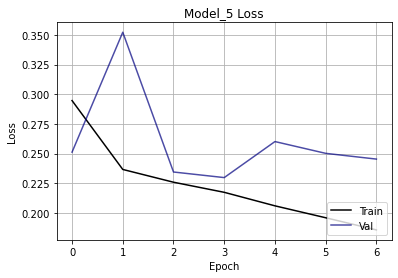

In [ ]:
plt.plot(history.history['loss'],color='black')
plt.plot(history.history['val_loss'],color='#000080',alpha=0.7)
plt.title('Model_5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.grid()
plt.savefig('m5loss.png', dpi=480, bbox_inches='tight')
plt.show()

Train f1_score: 0.8774199227016368
Test f1_score: 0.8031210451550869


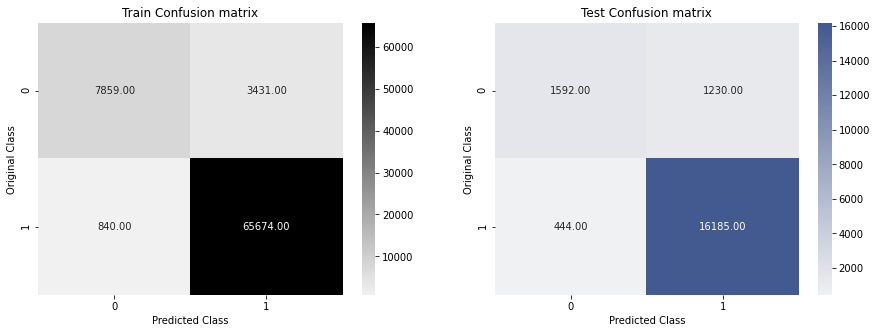

In [ ]:
y_train_pred1 = model.predict(x_train)
y_test_pred1 = model.predict(x_test)
y_train_pred = np.greater(y_train_pred1,0.5).astype(int)
y_test_pred = np.greater(y_test_pred1,0.5).astype(int)

print("Train f1_score:",f1_score(y_train,y_train_pred,average='macro'))

print("Test f1_score:",f1_score(y_test,y_test_pred,average='macro'))

confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'model_5.png')

### Stacking Ensemble 

In [ ]:
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
#loading models
model_1 = tf.keras.models.load_model('models/model_1.h5')
model_2 = tf.keras.models.load_model('models/model_2.h5')
model_3 = tf.keras.models.load_model('models/model_3.h5')
model_4 = tf.keras.models.load_model('models/model_4.h5')
model_5 = tf.keras.models.load_model('models/model_5.h5')



In [ ]:
#prediction of train data
y_train_pred1 = model_1.predict(X_train_encode)
y_train_pred2 = model_2.predict(X_train_encode_1)
y_train_pred3 = model_3.predict([trainX_txt, trainX_os, trainX_pt, trainX_st, trainX_pc, trainX_rfm, X_tr_num_1])
y_train_pred4 = model_4.predict([trainX_txt,x_tr_num])
y_train_pred5 = model_5.predict([trainX_txt,X_tr_num])


#prediction of test data
y_test_pred1 = model_1.predict(X_test_encode)
y_test_pred2 = model_2.predict(X_test_encode_1)
y_test_pred3 = model_3.predict([testX_txt, testX_os, testX_pt, testX_st, testX_pc, testX_rfm, X_te_num_1])
y_test_pred4 = model_4.predict([testX_txt,x_te_num])
y_test_pred5 = model_5.predict([testX_txt,X_te_num])


Hard Stacking

In [ ]:
train_set = np.stack((y_train_pred1[:,0],y_train_pred2[:,0],y_train_pred3[:,0],y_train_pred4[:,0],y_train_pred5[:,0]),axis=-1)
test_set = np.stack((y_test_pred1[:,0],y_test_pred2[:,0],y_test_pred3[:,0],y_test_pred4[:,0],y_test_pred5[:,0]),axis=-1)

clf = XGBClassifier(n_jobs=-1)
clf.fit(train_set,y_train)

y_train_pred = clf.predict(train_set)
y_test_pred = clf.predict(test_set)
# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8806977790665846
Test f1 score 0.8189993424344142


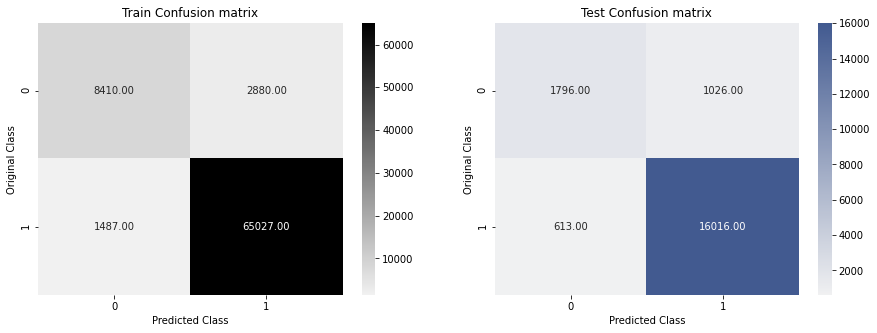

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'stacknn1.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/stacknn1.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/case study/models/stacknn1.sav']

Soft Stacking

In [ ]:

train_set = np.stack((np.greater(y_train_pred1,0.5).astype(int)[:,0],np.greater(y_train_pred2,0.5).astype(int)[:,0],
                      np.greater(y_train_pred3,0.5).astype(int)[:,0],np.greater(y_train_pred4,0.5).astype(int)[:,0],np.greater(y_train_pred5,0.5).astype(int)[:,0]),axis=-1)

test_set = np.stack((np.greater(y_test_pred1,0.5).astype(int)[:,0],np.greater(y_test_pred2,0.5).astype(int)[:,0],
                     np.greater(y_test_pred3,0.5).astype(int)[:,0],np.greater(y_test_pred4,0.5).astype(int)[:,0],np.greater(y_test_pred5,0.5).astype(int)[:,0]),axis=-1)

clf = XGBClassifier(n_jobs=-1)
clf.fit(train_set,y_train)


y_train_pred = clf.predict(train_set)
y_test_pred = clf.predict(test_set)
# printing train and test scores
print('Train f1 score',f1_score(y_train,y_train_pred,average='macro'))
print('Test f1 score',f1_score(y_test,y_test_pred,average='macro'))

Train f1 score 0.8762216710320837
Test f1 score 0.8245996128120232


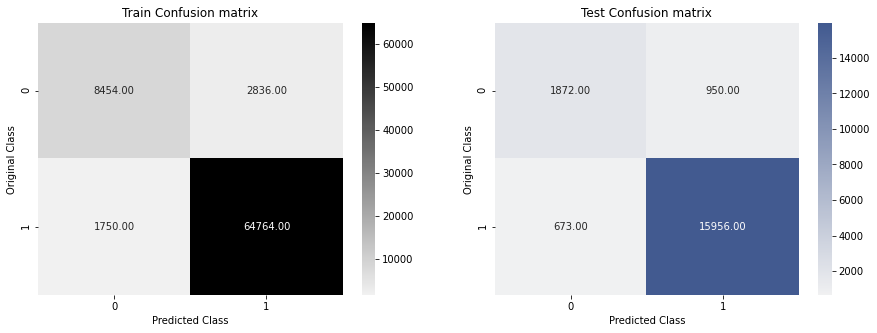

In [ ]:
confusion_matrices_plot(y_train,y_train_pred,y_test,y_test_pred,'stacknn2.png')

In [ ]:
#saving the model
filename = '/content/drive/MyDrive/case study/models/stacknn2.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/case study/models/stacknn2.sav']

## Summary

In [ ]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "train f1_score", "test f1-Score"]
x.add_row(['Model-1(Simple NN)','0.872603','0.806720'])
x.add_row([' ',' ',' '])
x.add_row(['Model-2(using CNN)','0.874031','0.809188']) 
x.add_row([' ',' ',' '])
x.add_row(['Model-3(LSTM)    ','0.863660','0.823890'])
x.add_row([' ',' ',' '])
x.add_row(['Model-4(LSTM)     ','0.86152', '0.812357'])
x.add_row([' ',' ',' '])
x.add_row(['Model-5(LSTM+CNN1d)     ','0.877419', '0.8031210'])
x.add_row([' ',' ',' '])
x.add_row(['Hard Stacking Ensemble','0.88069','0.81899'])
x.add_row([' ',' ',' '])
x.add_row(['Soft Stacking Ensemble','0.876221', '0.824599'])
print(x)

+--------------------------+----------------+---------------+
|          Model           | train f1_score | test f1-Score |
+--------------------------+----------------+---------------+
|    Model-1(Simple NN)    |    0.872603    |    0.806720   |
|                          |                |               |
|    Model-2(using CNN)    |    0.874031    |    0.809188   |
|                          |                |               |
|    Model-3(LSTM)         |    0.863660    |    0.823890   |
|                          |                |               |
|    Model-4(LSTM)         |    0.86152     |    0.812357   |
|                          |                |               |
| Model-5(LSTM+CNN1d)      |    0.877419    |   0.8031210   |
|                          |                |               |
|  Hard Stacking Ensemble  |    0.88069     |    0.81899    |
|                          |                |               |
|  Soft Stacking Ensemble  |    0.876221    |    0.824599   |
+-------

### Conclusion:

* Total 7 different Models are used for prediction.

* As our ML Problem is binary classification problem,I used for all models-
       a.Output Layer  : Dense layer with 1 unit and sigmoid activation
       b.Loss = Binary Cross-Entropy (minimized during the training )
       c. Metrics : accuracy & custom f1-score score 
       d.Callbacks : Early stopping,reduce learning rate ,tensorboard callback &ModelCheckpoints.

1. In Model-1 seven dense layers with He intializations, adam optimizer and other regularizations technique is used.The best output is shown above on the table.


2. In Model-2 Conv1D  with maxpooling1D layers are used.The activation function used is ```relu``` and the optimizer used is ```adam```.It has given f1-scores approximately equals to model-1.

3. In Model-3 LSTM Layer for text data and one non-trainable embedding Layer with 5 other trainable embedding layers for categorical features are used.The text feature, categorical features and numerical features are fed parrallely to the model and the output is concatenated and then passed through dense layer and then output is generated.I found that the test f1-score is improved from the previous results.

4. In Model-4  text features and other features are passed parllely and the output is concatenated and passed through dense layer and then output is generated.For text data one LSTM layer with non-trainable embedding Layer has been used.The f1-scores are close to the scores of model-3

5. In Model-5 both CNN1D and LSTM are used ,text features and other features are passed parllely and the output is concatenated and passed through dense layer and then output is generated.

6. In Stacking Ensemble model ,I tried both hard stacking and soft stacking models.I used above four as estimators and XGBoostClassifier as final_estimator.
